<a href="https://colab.research.google.com/github/polina-minaeva/GARCH-autoregressive-conditional-heteroskedasticity/blob/main/4_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%D0%B0%D0%B2%D1%82%D0%BE%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%BD%D0%BE%D0%B9_%D0%B3%D0%B5%D1%82%D0%B5%D1%80%D0%BE%D1%81%D0%BA%D0%B5%D0%B4%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%BD%D0%BE%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возьмем временной ряд о количестве рожденных девочек в Калифорнии и построим для него модель GARCH

In [ ]:
import pandas as pd
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import numpy as np

In [ ]:
 pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 10.0 MB/s eta 0:00:00


In [ ]:
from arch import arch_model

In [ ]:
#создаем функцию - тест стационарности

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
#рисуем временной ряд; для проверки стационарности также добавляем графики qqplot, acf, pacf

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [ ]:
#перед построением модели GARCH будем строить модель ARIMA, получим ряд остатков

def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j), trend='n').fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [ ]:
female_births = pd.read_csv('daily-total-female-births-in-cal.csv')["Count"]

Results of Dickey-Fuller Test:
Test Statistic                -1.296334e+01
p-value                        3.191205e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


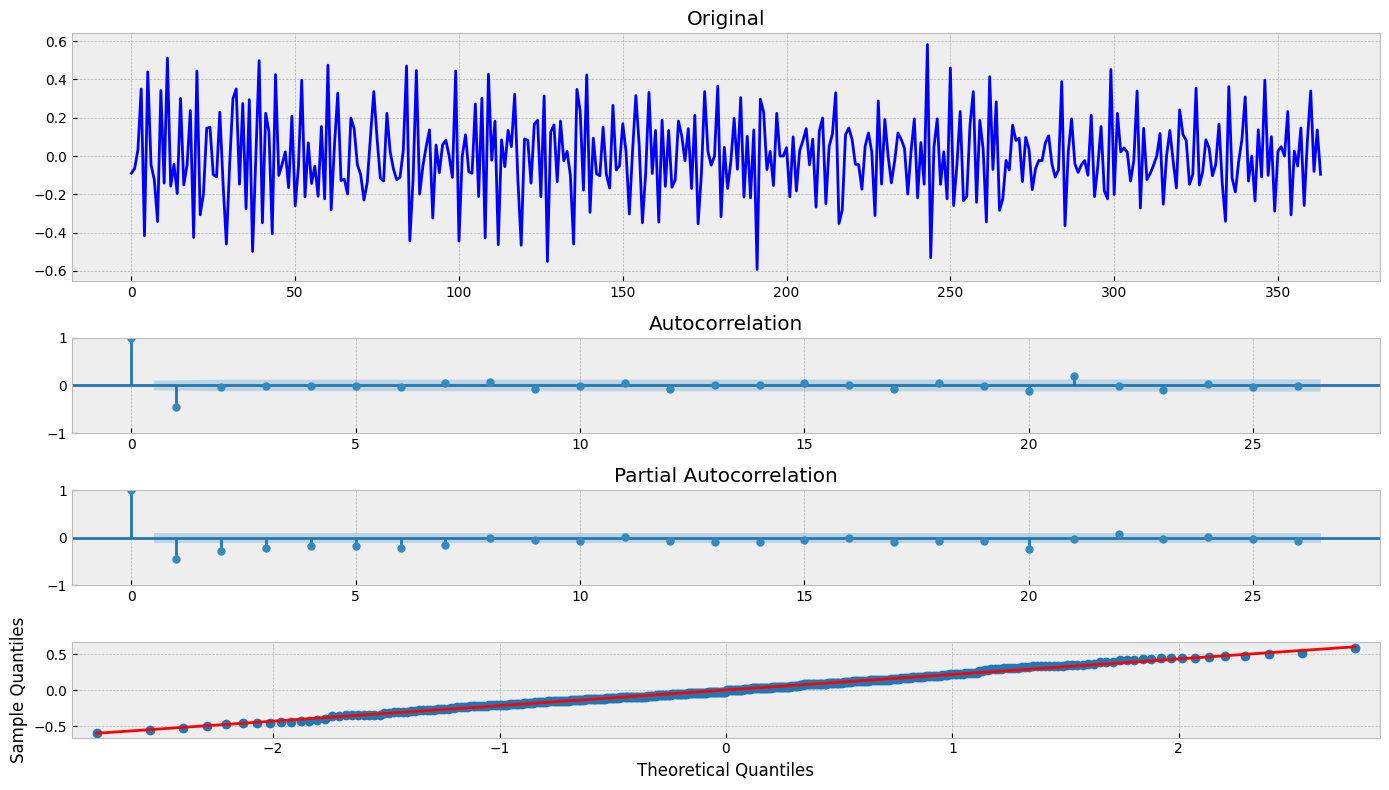

In [ ]:
female_births = boxcox(female_births, 0) #проводим логарифмирование данных
female_births = female_births[1:] - female_births[:-1] #убираем тренд
tsplot(female_births)

In [ ]:
#теперь применим на временном ряде функцию с моделью ARIMA

aic, order, mdl = _get_best_model(female_births)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

aic: -261.64742 | order: (1, 0, 1)


Results of Dickey-Fuller Test:
Test Statistic                 -19.227434
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    363.000000
Critical Value (1%)             -3.448494
Critical Value (5%)             -2.869535
Critical Value (10%)            -2.571029
dtype: float64


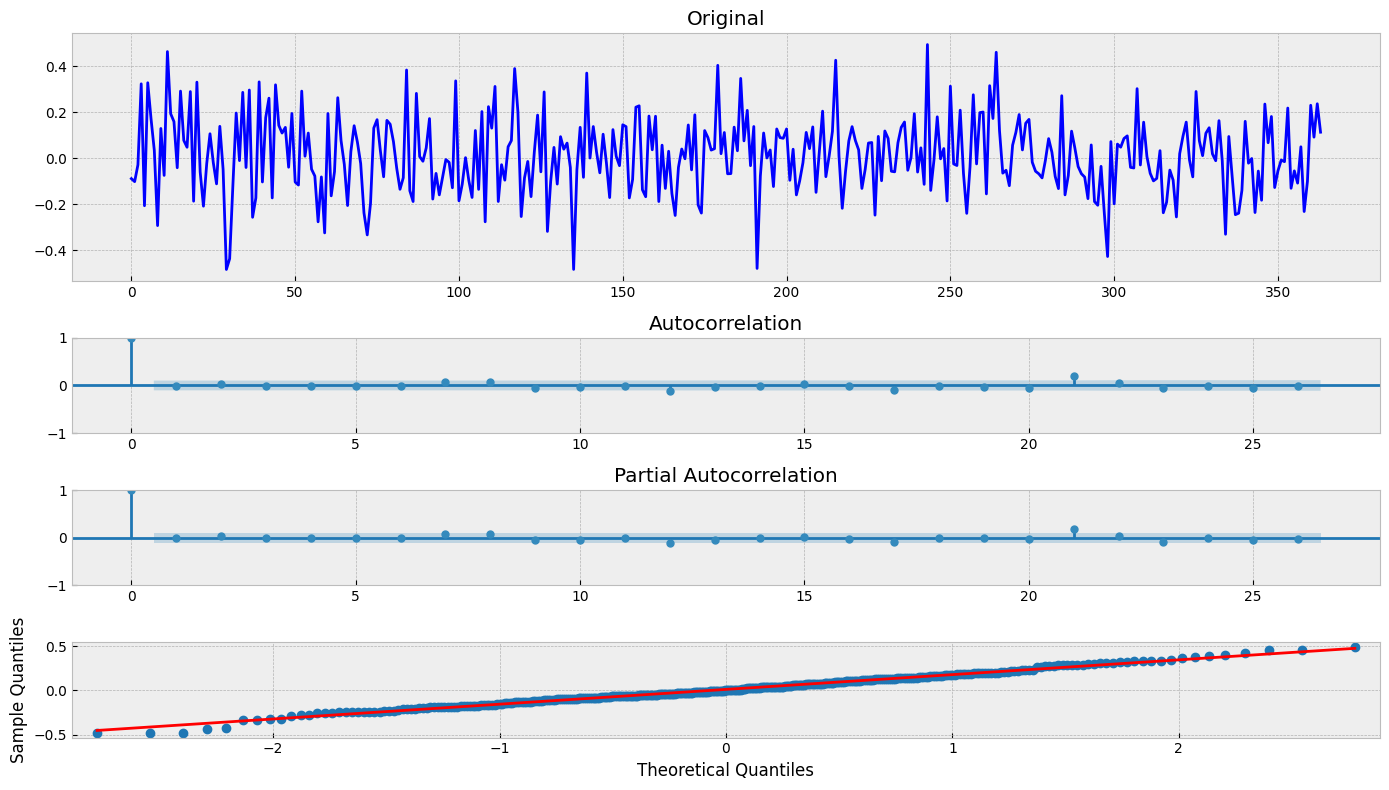

In [ ]:
tsplot(mdl.resid)

Ряд похож на стационарный, однако дисперсия переменчивая. Для ее выравнивания воспользуемся GARCH

In [ ]:
order #в ARIMA мы узнали параметры, которые можно использовать для GARCH

(1, 0, 1)

In [ ]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(female_births*100, p=p_, o=o_, q=q_, dist='StudentsT') #строим модель
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1632.3069794831358
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1631.4877958787597
Iteration:     15,   Func. Count:     98,   Neg. LLF: 1630.9061631775614
Iteration:     20,   Func. Count:    131,   Neg. LLF: 1630.7979641035367
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1630.7977587502255
            Iterations: 22
            Function evaluations: 153
            Gradient evaluations: 22
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1630.80
Distribution:      Standardized Student's t   AIC:                           3271.60
Method:                  Maximum Likelihood   BIC:                      

In [ ]:
forecast = res.forecast(horizon=300) #посмотрим прогнозы

[314.69070906 314.19637235 313.70392062 313.21334668 312.72464337
 312.23780356 311.75282015 311.26968604 310.7883942  310.3089376
 309.83130924 309.35550214 308.88150937 308.409324   307.93893914
 307.47034793 307.00354353 306.53851913 306.07526793 305.61378318
 305.15405814 304.69608609 304.23986036 303.78537429 303.33262125
 302.88159461 302.43228781 301.98469428 301.53880749 301.09462094
 300.65212813 300.21132262 299.77219796 299.33474775 298.8989656
 298.46484515 298.03238007 297.60156405 297.17239078 296.74485402
 296.31894753 295.89466507 295.47200047 295.05094755 294.63150017
 294.2136522  293.79739755 293.38273014 292.96964392 292.55813286
 292.14819095 291.73981221 291.33299068 290.92772042 290.52399552
 290.12181007 289.72115823 289.32203412 288.92443194 288.52834587
 288.13377014 287.74069898 287.34912666 286.95904747 286.5704557
 286.18334569 285.7977118  285.41354838 285.03084983 284.64961057
 284.26982503 283.89148767 283.51459296 283.13913542 282.76510954
 282.39250989

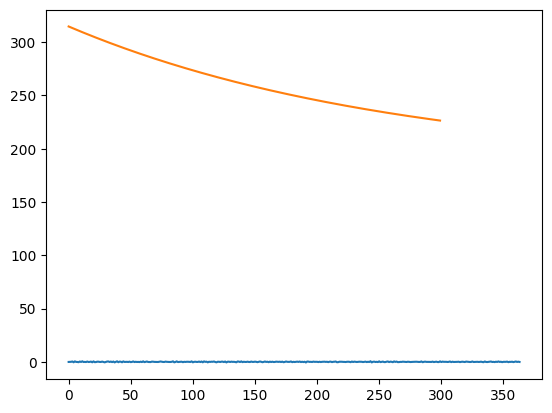

In [ ]:
plt.plot(female_births)
print(forecast.residual_variance.iloc[-1].values)
plt.plot([0]*300 + forecast.residual_variance.iloc[-1].values)

Results of Dickey-Fuller Test:
Test Statistic                -1.296334e+01
p-value                        3.191205e-24
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


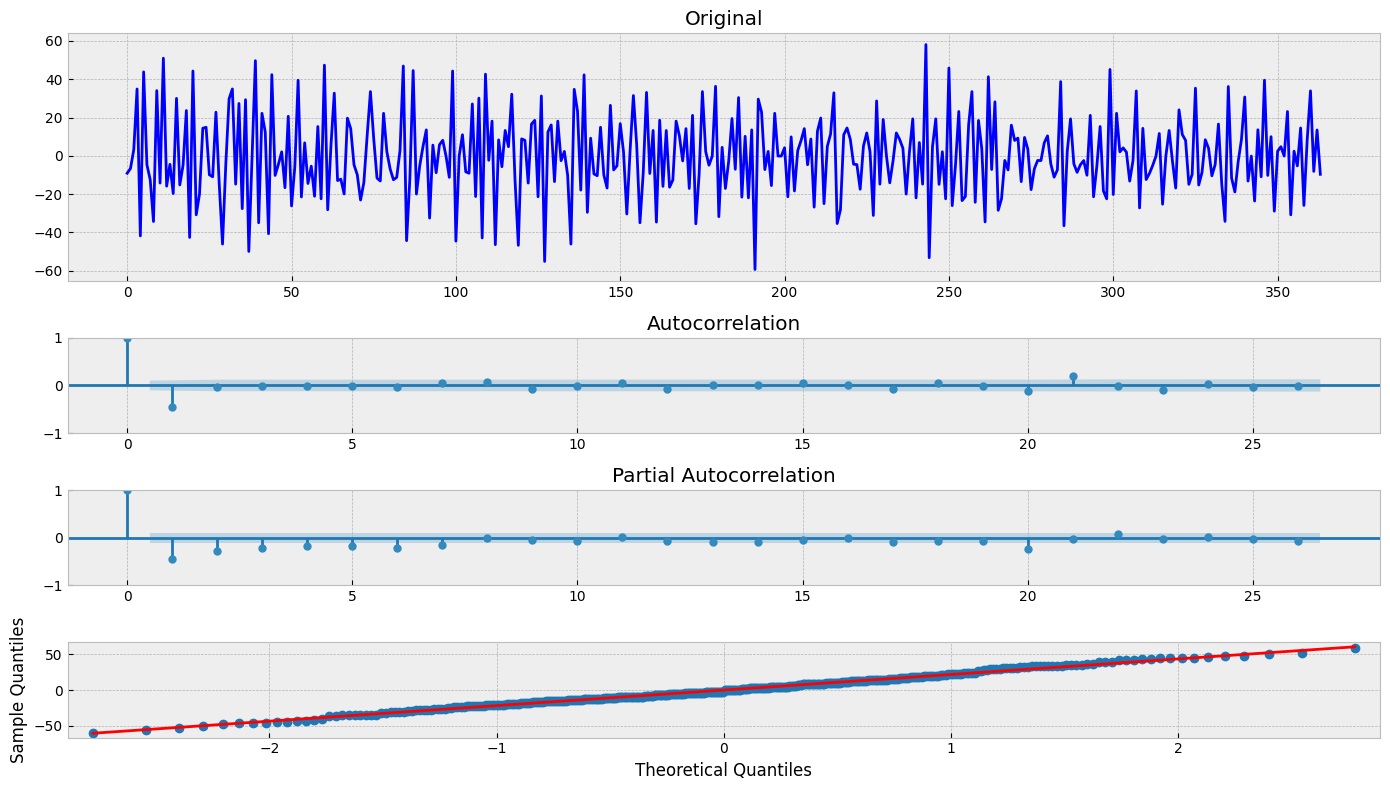

In [ ]:
tsplot(res.resid) #посмотрим на ряд остатков

Как мы видим, дисперсия выровнялась, а значит мы приблизили ряд к стационарности